# Lab 3 of course "Machine Learning"

# Unsupervised learning
### Titanic - Machine Learning from Disaster

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [64]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
print(train.shape)
train.sample(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,NaN,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
229,230,0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
606,607,0,3,"Karaic, Mr. Milan",male,30.0,0,0,349246,7.8958,NaN,S
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S


In [4]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
categorical_feats = {
    "Sex",
    "Embarked",
    "Survived"
}

for feat in categorical_feats:
    train[feat] = train[feat].astype("category")
    if feat != "Survived":
        test[feat] = test[feat].astype("category")

In [6]:
train.dtypes

PassengerId       int64
Survived       category
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [7]:
numerical_feats = train.select_dtypes(include=["int64", "float64"]).columns
numerical_feats

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
description = train.describe(include="all")
description

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.0,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,2.0,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,0.0,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,549.0,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,NaN,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,NaN,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,NaN,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,NaN,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,NaN,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,NaN,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
description["Cabin"]["unique"] / description["Cabin"]["count"]

0.7205882352941176

I make a decision on deleting whole __PassengerId__, __Cabin__ and __Name__ columns for their uninformativeness. Later we might come back to returning some of them if model won't train as expected.

In [11]:
useless_cols = ["PassengerId", "Cabin", "Name", "Ticket"]
train.drop(columns=useless_cols, inplace=True)
test.drop(columns=useless_cols, inplace=True)

In [12]:
median = train["Age"].median()

train["Age"].fillna(median, inplace=True)
train["Embarked"].fillna("S", inplace=True)

test["Age"].fillna(median, inplace=True)
test["Fare"].fillna(test["Fare"].median(), inplace=True)

In [13]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Encode _Sex_ and _Embarked_ columns

In [14]:
print(train["Sex"].value_counts(), "\n")
print(train["Embarked"].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64 

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [37]:
cols_to_encode = ["Sex", "Embarked"]

def encode(df, cols):
    encoder = OneHotEncoder(sparse_output=False)
    df_encoded = encoder.fit_transform(df[cols])

    encoded_data = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(cols))
    res_encoded = pd.concat([df, encoded_data], axis=1)
    return res_encoded


train_encoded = encode(train, cols_to_encode).drop(cols_to_encode, axis=1).drop("Survived", axis=1)
test_encoded = encode(test, cols_to_encode).drop(cols_to_encode, axis=1)

First we will train our model without __Ticket__ column for its high uniqueness and therefore low proneness to clusterization.

In [16]:
tmp_categorical_feats = ["Pclass", "SibSp", "Parch", "Sex", "Embarked"]
categorical_data = train

for col in tmp_categorical_feats:
    categorical_data[col] = categorical_data[col].astype("category")

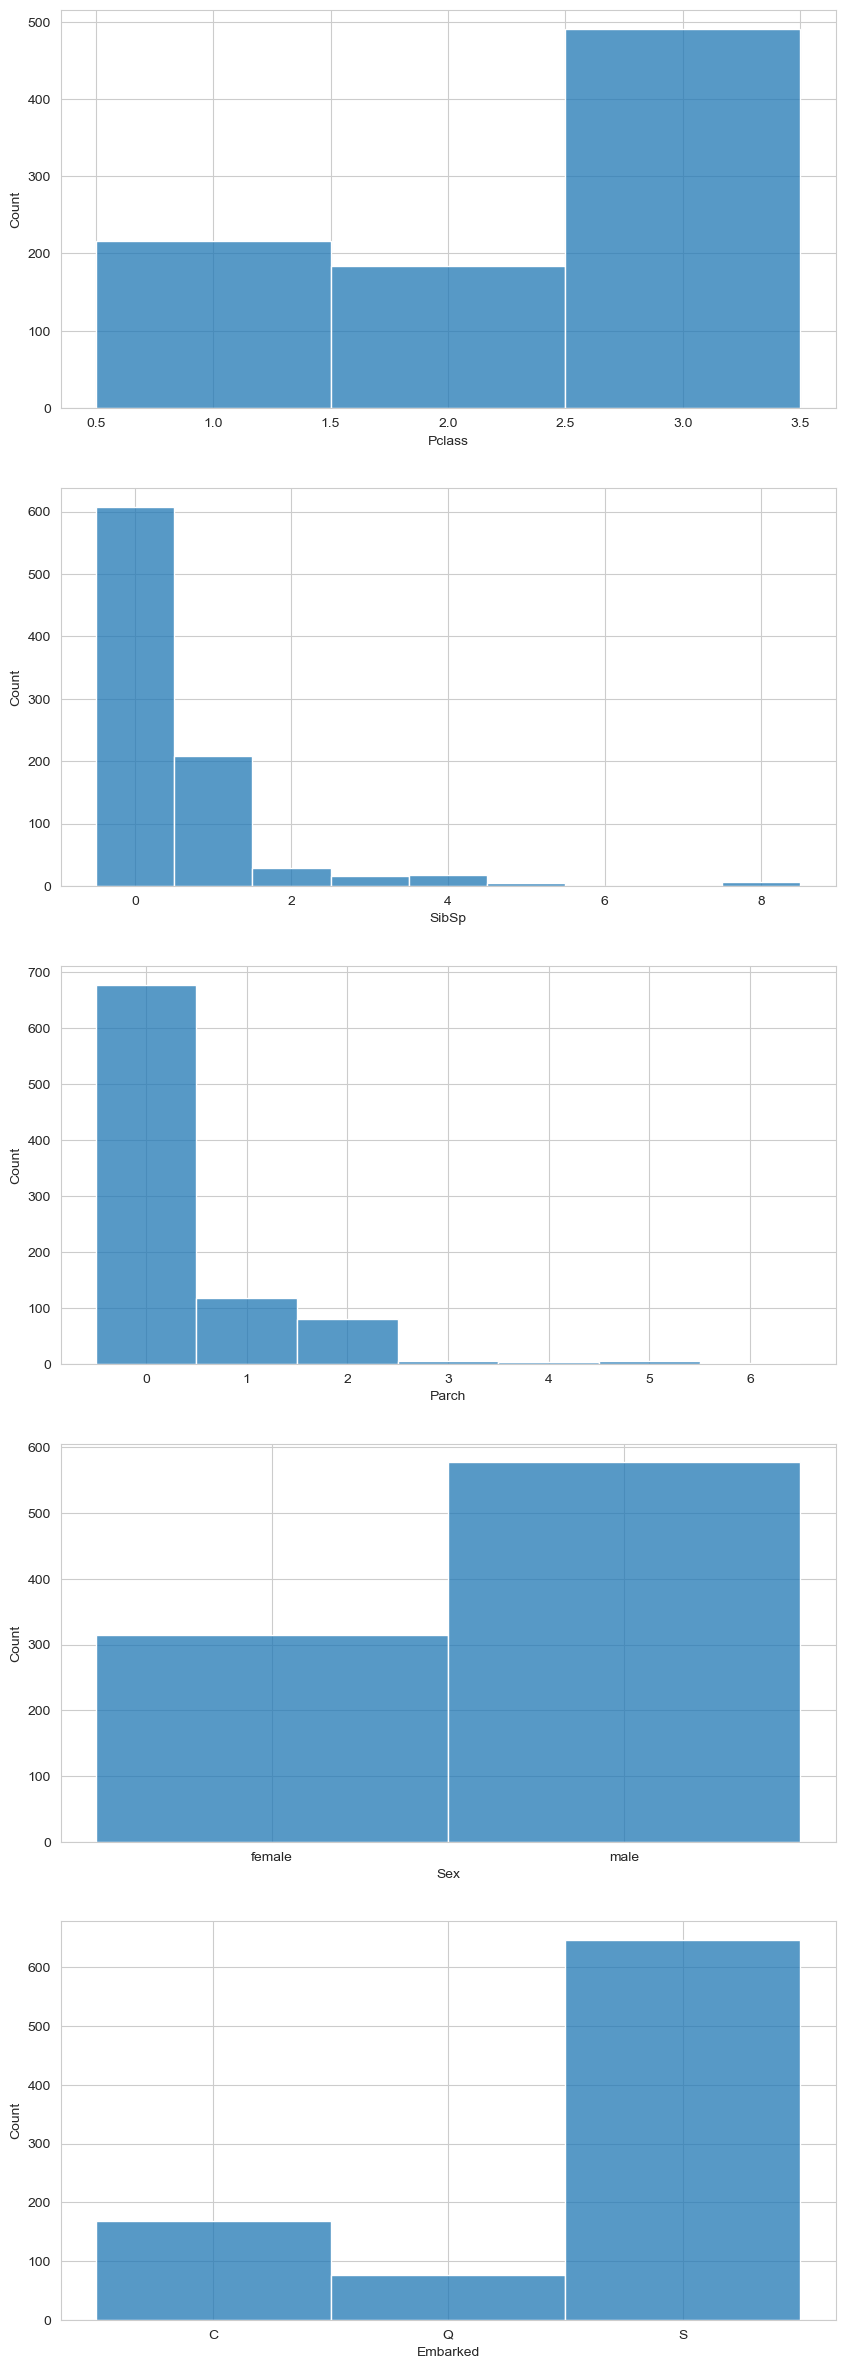

In [17]:
fig, axes = plt.subplots(len(tmp_categorical_feats), ncols=1)
fig.set_size_inches(10, 30)

for i, col in enumerate(tmp_categorical_feats):
    sns.histplot(data=categorical_data, x=col, kde=False, ax=axes[i])

plt.show()

In [18]:
numerical_feats = train.select_dtypes(include=["int64", "float64"]).columns

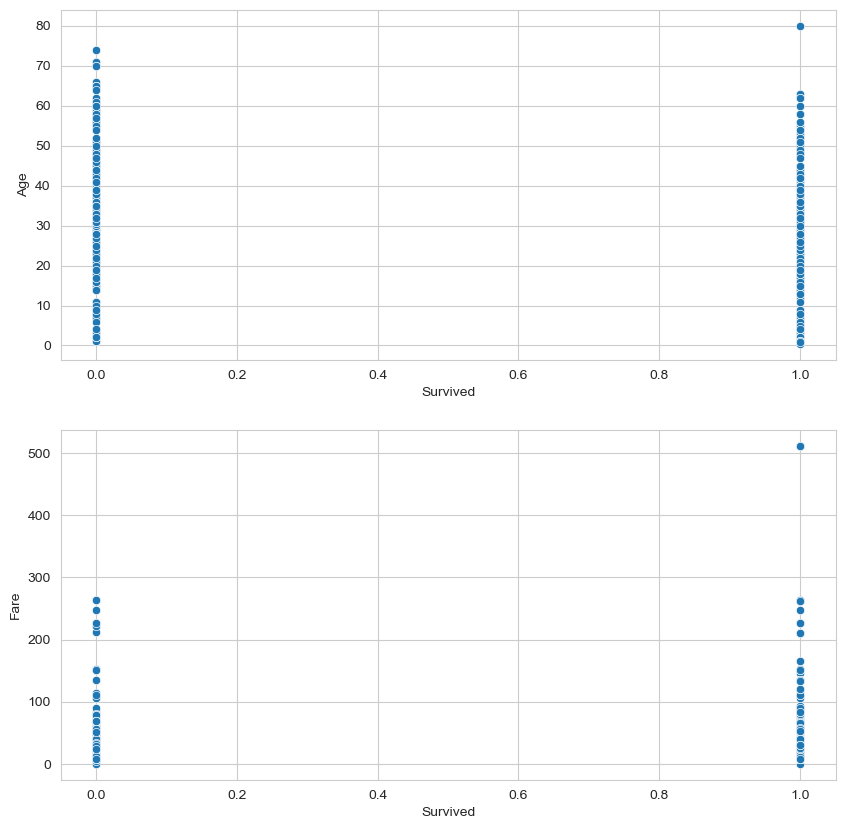

In [19]:
fig, axes = plt.subplots(len(numerical_feats), ncols=1)
fig.set_size_inches(10, 10)

for i, col in enumerate(numerical_feats):
    sns.scatterplot(y=categorical_data[col], x=categorical_data["Survived"], ax=axes[i])

plt.show()

From graphs above it is clear that fare almost does not correlate with the survival rate. However, from the age graph we can follow slight gap in survival for the passengers above 65 years old.

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import roc_auc_score, accuracy_score

In [105]:
def switch_clusters(clusters):
    return np.choose(clusters, [1, 0]).astype(np.int64)

In [38]:
sc = StandardScaler()
scaled_train = sc.fit_transform(train_encoded)
scaled_test = sc.fit_transform(test_encoded)

In [86]:
kmeans = KMeans(init="random", n_clusters=2, n_init=5, random_state=3)
kmeans.fit(scaled_train)

KMeans(init='random', n_clusters=2, n_init=5, random_state=3)

In [100]:
train_pred = switch_clusters(kmeans.labels_)

In [101]:
print(f"Train ROC_AUC: {roc_auc_score(train["Survived"], train_pred)}")
print(f"Train Accuracy: {accuracy_score(train["Survived"], train_pred)}")

Train ROC_AUC: 0.7688860128463234
Train Accuracy: 0.7878787878787878


In [107]:
test_pred = switch_clusters(kmeans.predict(scaled_test))

test_output = pd.DataFrame(test["PassengerId"])
test_output["Survived"] = test_pred

test_output.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [108]:
test_output.to_csv("./data/output.csv", index=False)

In [136]:
X = train[["Fare", "Age"]]

def plot_clusters(labels):
    plt.figure(figsize=(10, 6))
    
    plt.scatter(X.iloc[labels == 1]["Fare"], X.iloc[labels == 1]["Age"], c="blue", label="Survived")
    plt.scatter(X.iloc[labels == 0]["Fare"], X.iloc[labels == 0]["Age"], c="red", label="Died")
    
    plt.xlabel("Fare")
    plt.ylabel("Age")
    plt.title("Clustering of Titanic Passengers")
    plt.legend()
    plt.show()

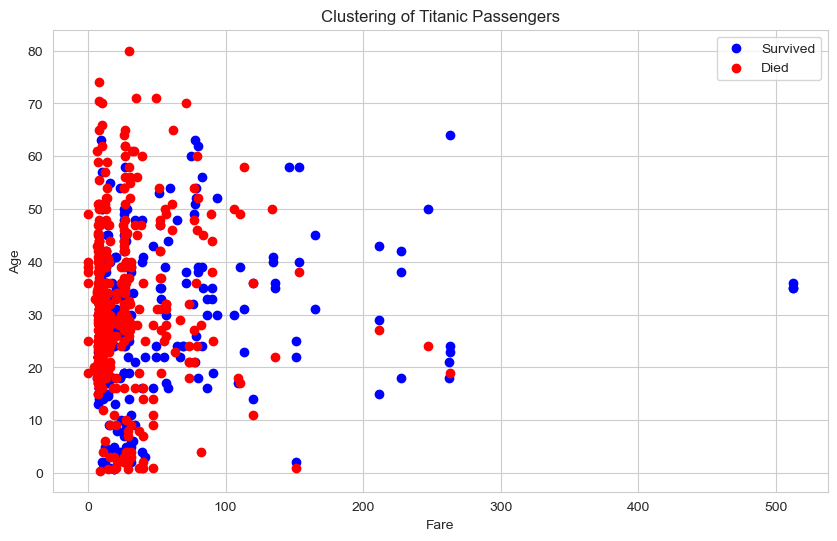

In [137]:
plot_clusters(train_pred)

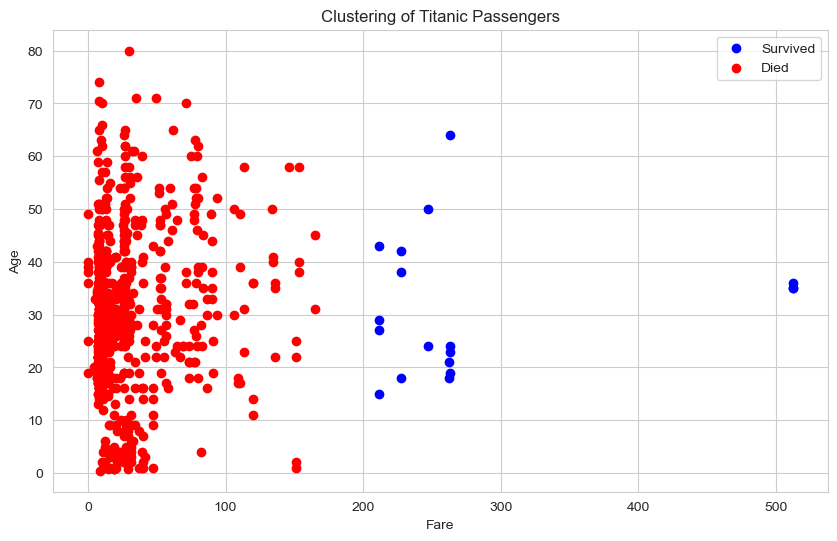

In [139]:
ac = AgglomerativeClustering(n_clusters=2)
ac.fit(train_encoded)
plot_clusters(ac.labels_)